In [1]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

# libraries
import numpy as np
import pandas as pd

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#### Reading Cancer data

In [2]:
import pickle
file = open("data_rus_adasyn_risk2","rb")
X_train = pickle.load(file)
y_train = pickle.load(file)
X_test = pickle.load(file)
y_test = pickle.load(file)
file.close()

In [3]:
X_train.head(2)

,menopaus_0,agegrp_2,agegrp_3,agegrp_4,agegrp_5,agegrp_6,agegrp_7,agegrp_8,agegrp_9,agegrp_10,...,race_5,hispanic_0,hispanic_1,bmi_3,bmi_4,agefirst_1,agefirst_2,nrelbc_0,nrelbc_2,lastmamm_1
0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0


In [4]:
X_test.head(2)

,menopaus_0,agegrp_2,agegrp_3,agegrp_4,agegrp_5,agegrp_6,agegrp_7,agegrp_8,agegrp_9,agegrp_10,...,race_5,hispanic_0,hispanic_1,bmi_3,bmi_4,agefirst_1,agefirst_2,nrelbc_0,nrelbc_2,lastmamm_1
1,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [5]:
X_train.shape

(16577, 25)

In [6]:
X_test.shape

(59501, 25)

In [7]:
from collections import Counter

Counter(y_train)

Counter({0: 8586, 1: 7991})

# Model Building on Cancer Data

## <span style="color:blue">Model 3 - SVM with SGD</span>

### Default Hyperparameters

Let's first fit a random forest model with default hyperparameters.

In [8]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score

def model_stats(X, y, y_pred, model):

    cm = confusion_matrix(y, y_pred)
    print("Confusion Matrix ->")
    print(cm)

    TP = cm[1,1] # true positive 
    TN = cm[0,0] # true negatives
    FP = cm[0,1] # false positives
    FN = cm[1,0] # false negatives
    
    print("Accuracy:",accuracy_score(y, y_pred))
    sensi=TP / float(TP+FN)
    speci=TN / float(TN+FP)
    # Let's see the sensitivity of our model
    print("Sensitivity:", sensi)

    # Let us calculate specificity
    print("Specificity:", speci)
    print("Average of Sensitivity and Specificity:", (sensi+speci)/2)

    # Let us calculate precision
    print("Precision",TP / float(TP+FP))
    print("MCC ", metrics.matthews_corrcoef(y, y_pred))
    print("F1 ", metrics.fbeta_score(y, y_pred, beta = 1))
    print("F2 ", metrics.fbeta_score(y, y_pred, beta = 2))
    print("F3 ", metrics.fbeta_score(y, y_pred, beta = 3))
    
    # Predicting probability for roc_auc
    '''pred_probs = model.predict_proba(X)[:,1]
    print("ROC-AUC : {:2.2}".format(roc_auc_score(y, pred_probs)))

    # Plotting ROC curve
    fpr, tpr, thresholds = roc_curve(y, pred_probs, drop_intermediate = False )
    auc_score = roc_auc_score(y, pred_probs)
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()'''
    

In [9]:
# Importing random forest classifier from sklearn library
from sklearn.linear_model import SGDClassifier

In [10]:
sgd = SGDClassifier(random_state = 100)

# fit
sgd.fit(X_train,y_train)

SGDClassifier(random_state=100)

In [11]:
# Let's check the evaluation metrics of our default model

# Making predictions
y_pred_train_def = sgd.predict(X_train) # For train data
y_pred_test_def = sgd.predict(X_test) # For test data

#### Evaluating model on imbalanced train data with default parameters

In [12]:
# For train
model_stats(X_train, y_train, y_pred_train_def, sgd)

Confusion Matrix ->
[[4666 3920]
 [2941 5050]]
Accuracy: 0.5861132894974965
Sensitivity: 0.631960956075585
Specificity: 0.5434428138830655
Average of Sensitivity and Specificity: 0.5877018849793252
Precision 0.5629877369007804
MCC  0.1758862951993784
F1  0.5954837568539592
F2  0.6168466311623589
F3  0.624312329241306


#### Evaluating model on imbalanced test data with default parameters

In [13]:
# For test
model_stats(X_test, y_test, y_pred_test_def, sgd)

Confusion Matrix ->
[[30572 27358]
 [  627   944]]
Accuracy: 0.5296717702223492
Sensitivity: 0.6008911521323997
Specificity: 0.5277403763162437
Average of Sensitivity and Specificity: 0.5643157642243217
Precision 0.03335453324853367
MCC  0.041296037970886976
F1  0.06320088374117096
F2  0.1364714046145839
F3  0.22242642727551185


### Hyperparameter Tuning : Grid Search to Find Optimal Hyperparameters


By default the loss is 'hinge'

In [14]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold

#Create a cross validation scheme
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

In [15]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'penalty' : ['l1', 'l2', 'elasticnet'] 
}

sgd = SGDClassifier(random_state = 100)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = sgd, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best balanced accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    7.3s finished


best balanced accuracy 0.5875886371552385
SGDClassifier(penalty='l1', random_state=100)


In [16]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_iter' : [400, 600, 800] 
}

sgd = SGDClassifier(penalty='l1', random_state = 100)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = sgd, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best balanced accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.1s finished


best balanced accuracy 0.5877763718235739
SGDClassifier(max_iter=600, penalty='l1', random_state=100)


In [17]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10] 
}

sgd = SGDClassifier(max_iter=600, penalty='l1', random_state = 100)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = sgd, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best balanced accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.6s finished


best balanced accuracy 0.5877763718235739
SGDClassifier(max_iter=600, penalty='l1', random_state=100)


In [18]:
### Model using best parameters obtained from grid search

sgd = SGDClassifier(max_iter=600, penalty='l1', random_state=100)

# Fit the grid search to the data
sgd.fit(X_train, y_train)

SGDClassifier(max_iter=600, penalty='l1', random_state=100)

In [19]:
#### Model evaluation on train data

# Predicting on test dataframe using predict
y_pred_train = sgd.predict(X_train)

model_stats(X_train, y_train, y_pred_train, sgd)

Confusion Matrix ->
[[4456 4130]
 [2356 5635]]
Accuracy: 0.6087349942691681
Sensitivity: 0.7051683143536479
Specificity: 0.5189843931982296
Average of Sensitivity and Specificity: 0.6120763537759388
Precision 0.5770609318996416
MCC  0.22764942256125537
F1  0.6347150259067359
F2  0.6751899158858348
F3  0.6898535820968612


In [20]:
sgd.coef_

array([[2.03867359e-01, 1.00480838e+02, 9.91856241e+01, 1.00807942e+02,
        1.01003978e+02, 1.00999679e+02, 1.01020902e+02, 1.00996425e+02,
        1.01015015e+02, 1.00977664e+02, 3.05752415e-02, 7.52998982e-02,
        3.43897691e-02, 1.53450110e-01, 2.04495893e+02, 1.84926906e-01,
        1.91143504e+00, 6.55464576e-02, 1.34180299e-02, 6.87280441e-02,
        4.05817417e-02, 1.74600415e-01, 8.38968795e-02, 5.28240367e-01,
        5.32506788e-02]])

In [21]:
# List of cols with their coefficients
val=sgd.coef_.reshape(-1)
coef = (pd.DataFrame(val, index=X_train.columns, columns = ['Coefficients'] )).reset_index()
coef = coef.rename(columns={'index':'Features'})
coef = coef.sort_values(by = 'Coefficients', ascending=False)
coef

,Features,Coefficients
14,race_4,204.495893
6,agegrp_7,101.020902
8,agegrp_9,101.015015
4,agegrp_5,101.003978
5,agegrp_6,100.999679
7,agegrp_8,100.996425
9,agegrp_10,100.977664
3,agegrp_4,100.807942
1,agegrp_2,100.480838
2,agegrp_3,99.185624


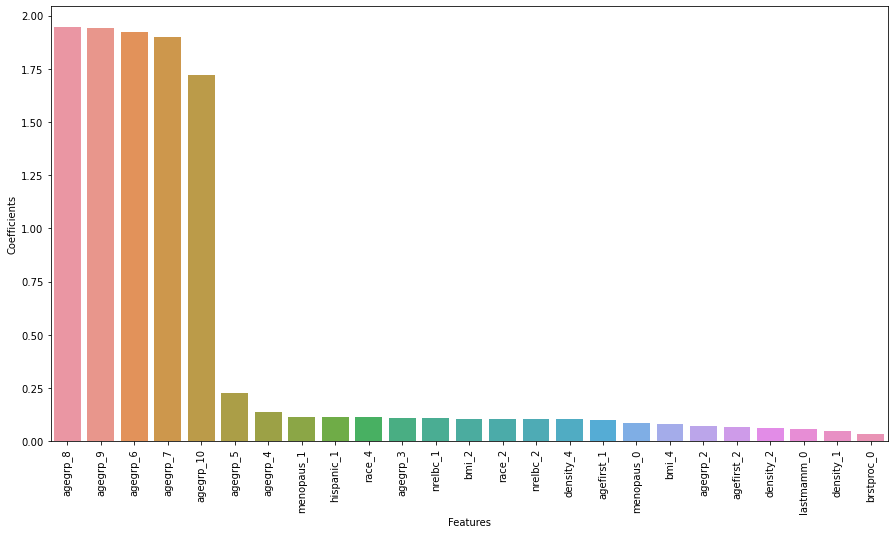

In [24]:
# Plotting important features against their coefficients
plt.figure(figsize=(15,8))
plt.subplot(111)
ax1 = sns.barplot(x = coef['Features'], y = coef['Coefficients'])
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90, fontsize=10)
#plt.ylabel('Coefficients')
plt.show()

#### Model evaluation on test data

In [22]:
# Predicting on test dataframe using predict

y_pred_test = sgd.predict(X_test)
model_stats(X_test, y_test, y_pred_test, sgd)

Confusion Matrix ->
[[28388 29542]
 [  509  1062]]
Accuracy: 0.49494966471151747
Sensitivity: 0.6760025461489497
Specificity: 0.4900397030899361
Average of Sensitivity and Specificity: 0.5830211246194429
Precision 0.03470134622925108
MCC  0.053265129708577275
F1  0.06601398601398602
F2  0.14394925178919973
F3  0.2373555639988378


In [23]:
from sklearn.calibration import CalibratedClassifierCV
ccv = CalibratedClassifierCV(sgd, cv='prefit')
ccv.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(max_iter=600, penalty='l1',
                                                    random_state=100),
                       cv='prefit')

In [24]:
# Predicting probability for roc_auc
def cal_roc(model, X, y):
    pred_probs = model.predict_proba(X)[:,1]
    print("ROC-AUC : {:2.2}".format(roc_auc_score(y, pred_probs)))

    # Plotting ROC curve
    fpr, tpr, thresholds = roc_curve(y, pred_probs, drop_intermediate = False )
    auc_score = roc_auc_score(y, pred_probs)
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

ROC-AUC : 0.6


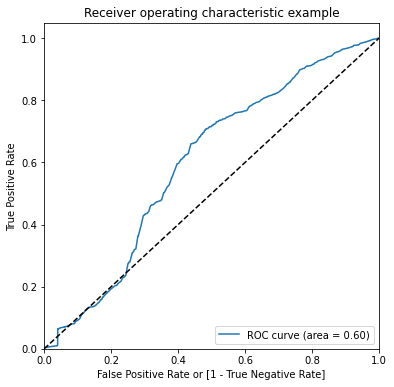

In [25]:
cal_roc(ccv, X_train, y_train)

ROC-AUC : 0.57


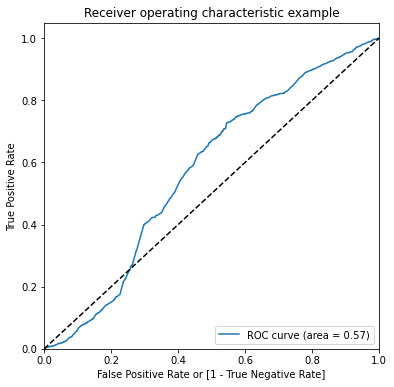

In [26]:
cal_roc(ccv, X_test, y_test)